# SODA 3.4.2 Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.9549c36e02ad498fa637d2598a9548dd/status,


In [20]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import gcsfs
import xmitgcm
import xgcm
import json
import fsspec

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)#, decode_times=False)
#with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
#    topo = xr.open_dataset(fp)

In [5]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [6]:
# notice i'm prepending `gs://` here, so `fsspec.open` can infer filesystem
url_topo = 'gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc'

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)

topo = xr.open_dataset(fsspec.open(url_topo, token=token).open(), engine="scipy")

## <font color='Green'>Slice to WG region</font>

In [7]:
#WG boundaries (80˚S, 57˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 208 #-57.08962246
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 208 #-57.02158171
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [8]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [9]:
ds_wg = ocean.isel(**lat_range, **lon_range)

In [10]:
depth_wg = topo.depth.isel(**lat_range_top, **lon_range_top)

In [11]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

salt25 = ds_wg.salt.sel(time='1993-12-25').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})
salt04 = ds_wg.salt.sel(time='1994-01-04').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})

In [12]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

#avging the two endpts to insert onto 1993-12-30 since there is a spike on that date due to nudging
salt30_ds = (salt25+salt04)/2
salt30 = salt30_ds.salt

In [13]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

#inserting avged salt value on 1993-12-30 date into ds_wg
ds_wg['salt'][72] = salt30[0]

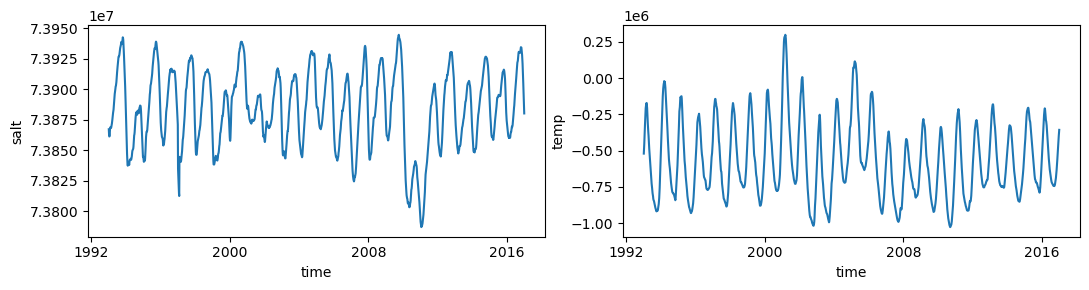

In [16]:
#spike in salt in Jan 1997
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

In [21]:
#going to insert avg'd values from dec & feb into jan
dec = ds_wg.salt.sel(time='1996-12')
jan = ds_wg.salt.sel(time='1997-01')
feb = ds_wg.salt.sel(time='1997-02')

#creating new jan object with avg'd values from prev and next months
for i in range(6):
    jan[i] = ((dec[i] + feb[i]) / 2)
    
jan_range = np.arange(292, 298)

#plugging new jan values into ds_wg
for i in range(6):
    for j in jan_range:
        ds_wg.salt[j] = jan[i]

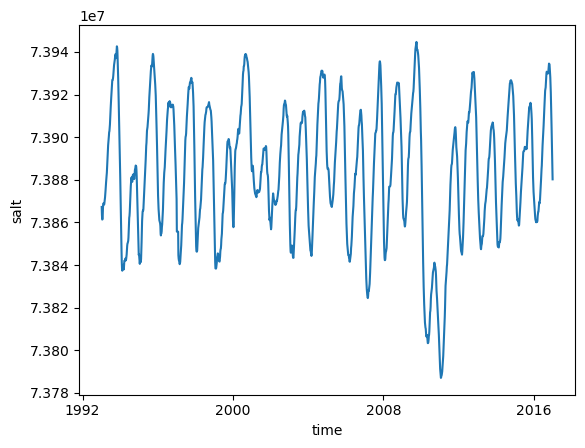

In [22]:
ds_wg.salt.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

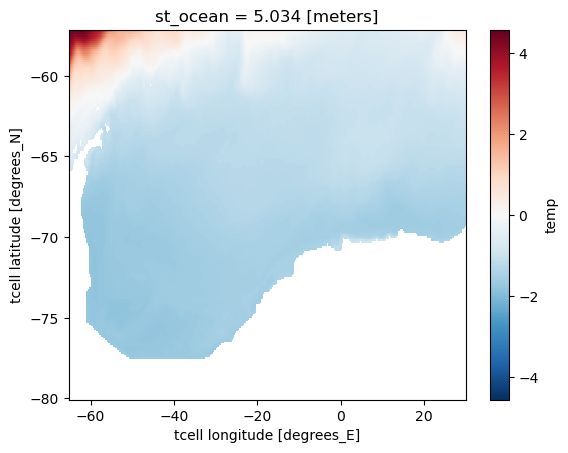

In [23]:
#testing to see if correctly sliced desired region
sst_mean = ds_wg.temp.isel(st_ocean=0).sel(time=slice('1997-02-15', '2019')).mean(dim='time')
sst_mean.plot()

In [26]:
depth_wg_interp = depth_wg.interp(coords={'grid_y_T':sst_mean.yt_ocean, 
                                          'grid_x_T':sst_mean.xt_ocean})

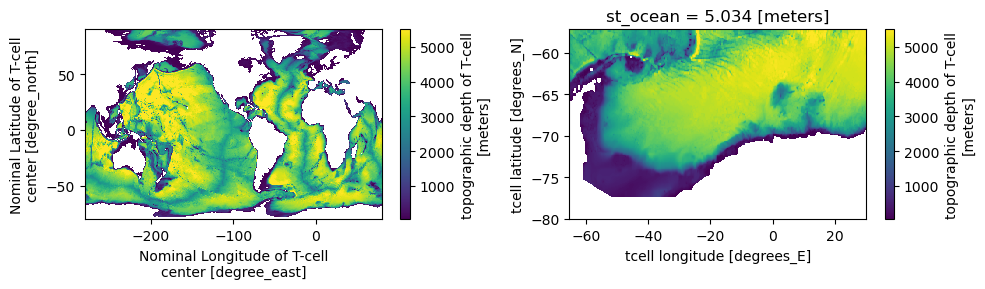

In [30]:
#spike in salt in Jan 1997
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10, 3))
topo.depth.plot(ax=ax0)
depth_wg_interp.plot(ax=ax1)
plt.tight_layout();

In [31]:
depth_wg_interp.to_netcdf('depth_wg_interp.nc', mode='w')

## <span style='color:Red'> Bottom Potential Temperatures

In [32]:
#999 is ocean, 111 is land
hfacc = ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull(), 999).where(ds_wg.temp < 999, 111)

In [33]:
hfacc

,Array,Chunk
Bytes,29.08 GiB,15.12 MiB
Shape,"(1970, 50, 208, 381)","(1, 50, 208, 381)"
Count,10 Graph Layers,1970 Chunks
Type,float32,numpy.ndarray


In [34]:
#999 is ocean, 111 is land
depth_max = (ds_wg.st_ocean.where(hfacc == 999)).max(dim='st_ocean').load()

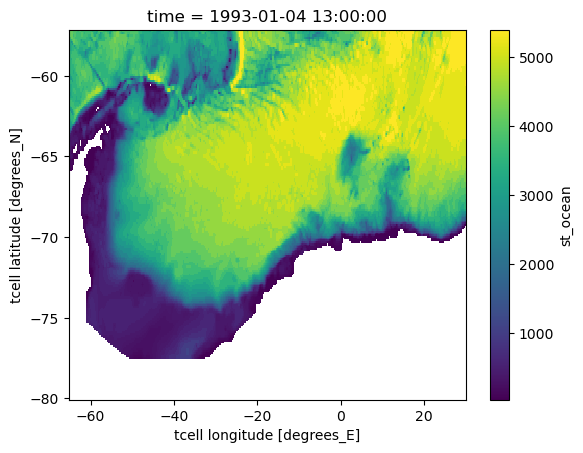

In [35]:
depth_max[0].plot()

In [36]:
depth_surf = (ds_wg.st_ocean.where(hfacc == 999)).min(dim='st_ocean').load()

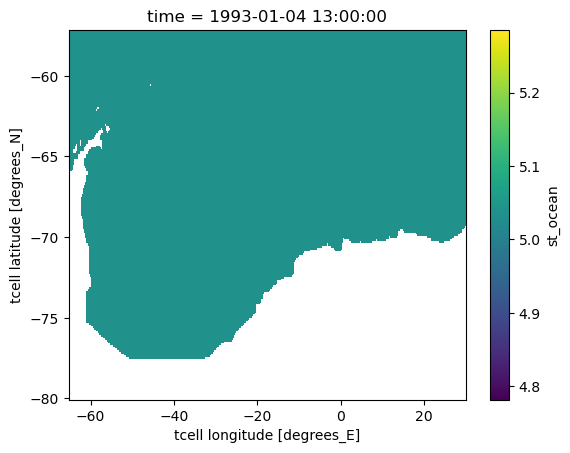

In [37]:
depth_surf[0].plot()

In [42]:
hfacc_file = hfacc[0].to_dataset(name='hfacc')

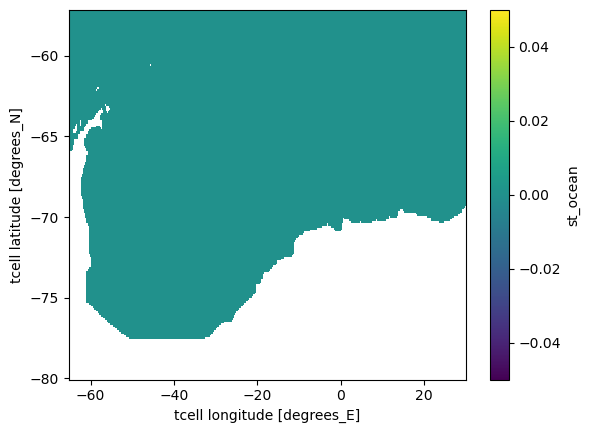

In [38]:
#depth doesn't change in time
depth_max.std(dim='time').plot()

In [39]:
depth_max = depth_max[0]

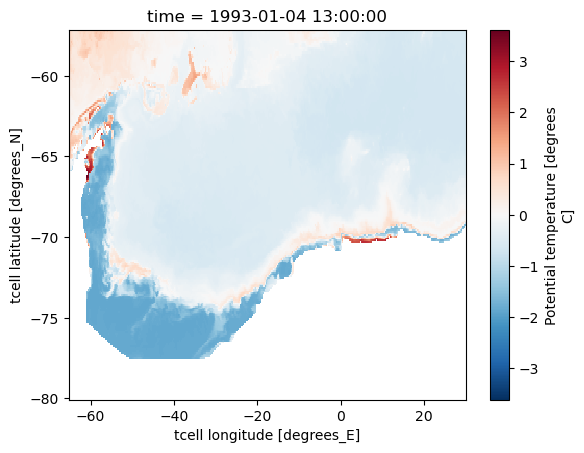

In [40]:
ds_wg.temp[0].sel(st_ocean=depth_max, method='nearest').plot()

In [41]:
temp_mean = ds_wg.temp.mean(dim='time').load()

In [43]:
bottom_temp = temp_mean.sel(st_ocean=depth_max, method='nearest')

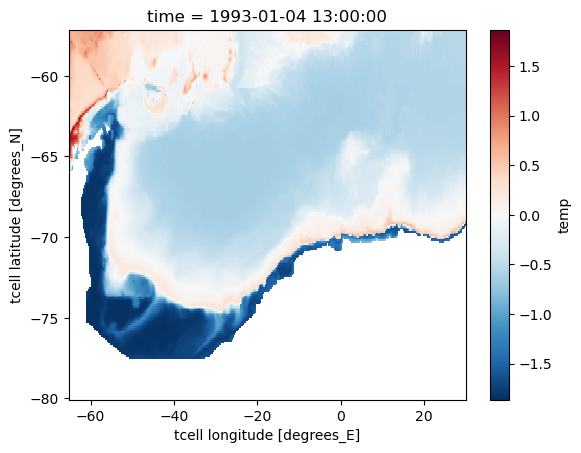

In [44]:
bottom_temp.plot()

In [46]:
swap = bottom_temp.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})
bottom_temp = swap.assign_coords({"lon": swap.xt_ocean.values, 'lat':swap.yt_ocean}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

## Plotting

In [47]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

In [48]:
lon = bottom_temp.lon
lat = bottom_temp.lat

In [49]:
d = depth_wg_interp.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})
depth = d.assign_coords({"lon": d.xt_ocean.values, 'lat':d.yt_ocean}).drop(['grid_y_T', 'grid_x_T', 'st_ocean',
                                                                            'yt_ocean', 'xt_ocean'])

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


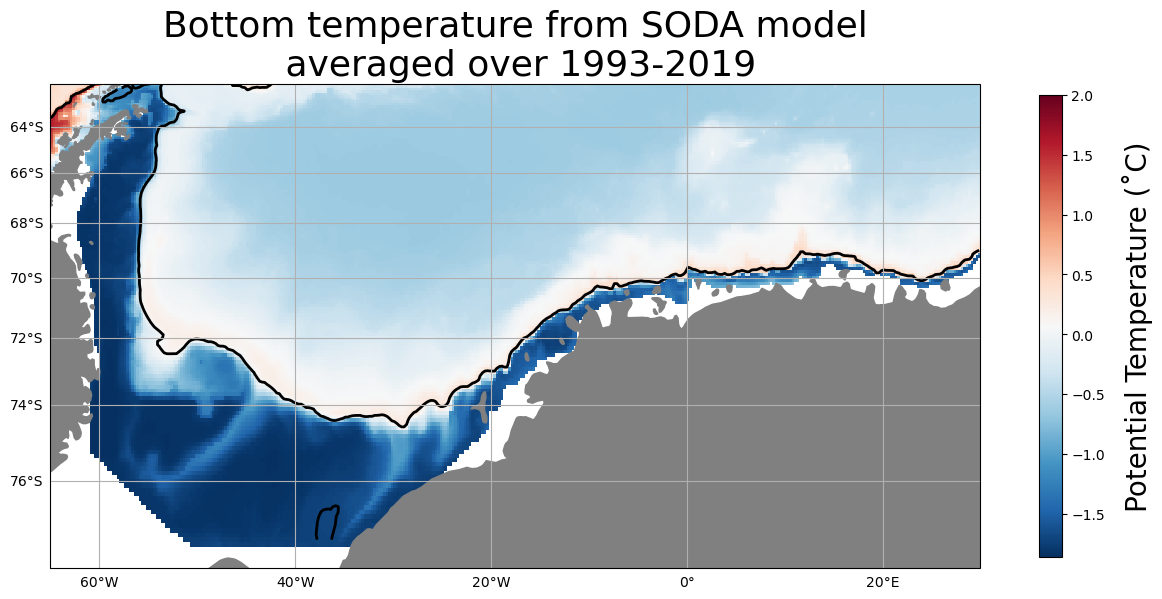

In [50]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Bottom temperature from SODA model\n averaged over 1993-2019', fontsize=26)
plt.savefig('bot-temp-soda-1kmisobath.pdf');

In [51]:
bottom_temp.to_netcdf('bottom_temp.nc', mode='w')

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [52]:
temp_std = ds_wg.temp.std(dim='time').load()

In [53]:
bottom_temp_std = temp_std.sel(st_ocean=depth_max, method='nearest')

In [54]:
swap_dim = bottom_temp_std.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [55]:
bottom_temp_std = swap_dim.assign_coords({"lon": swap_dim.xt_ocean.values, 
                                          'lat':swap_dim.yt_ocean.values}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


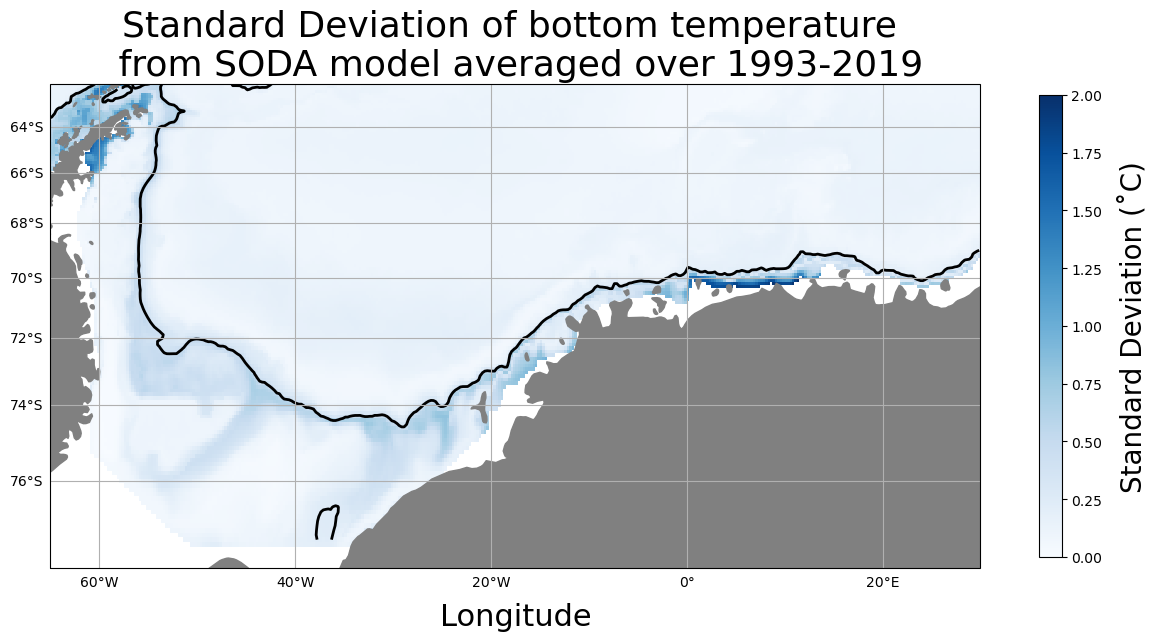

In [56]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_temp_std, transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=22)

plt.title('Standard Deviation of bottom temperature \n from SODA model averaged over 1993-2019', fontsize=26)
plt.savefig('std-bot-temp-soda-1kmisobath.pdf');

In [57]:
bottom_temp_std.to_netcdf('bottom_temp_std.nc')

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity

In [58]:
#999 is ocean, 111 is land
hfacc_salt = ds_wg.salt.where(ds_wg.salt == ds_wg.salt.notnull(), 999).where(ds_wg.salt < 999, 111)

In [59]:
#999 is ocean, 111 is land
depth_max_salt = (ds_wg.st_ocean.where(hfacc_salt == 999)).max(dim='st_ocean').load()

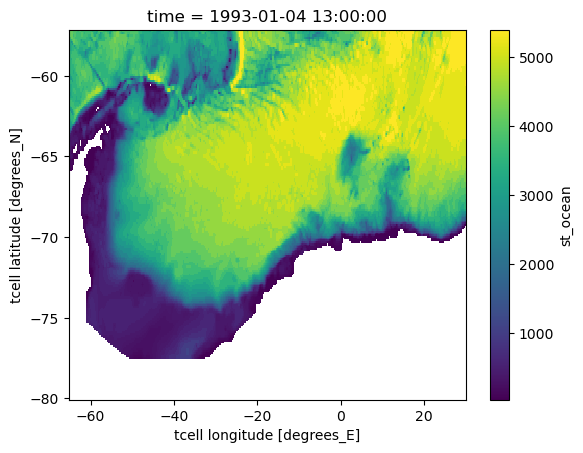

In [60]:
depth_max_salt[0].plot()

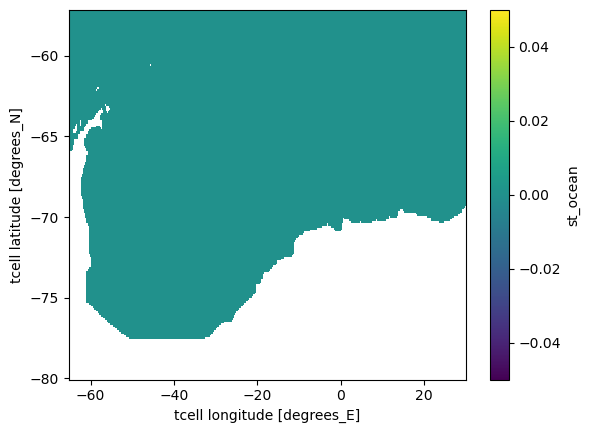

In [61]:
#depth doesn't change in time
depth_max_salt.std(dim='time').plot()

In [62]:
depth_max_salt = depth_max_salt[0]

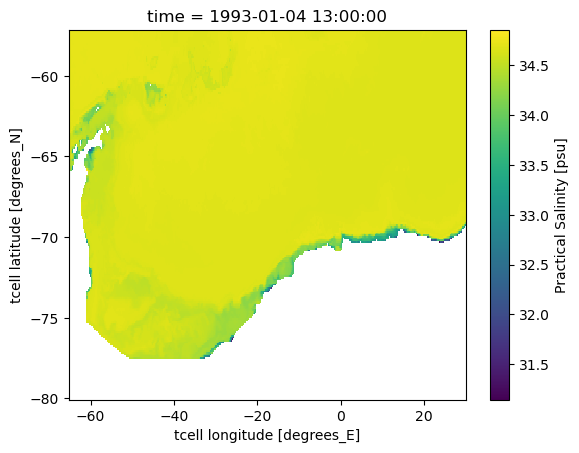

In [63]:
ds_wg.salt[0].sel(st_ocean=depth_max_salt, method='nearest').plot()

In [64]:
salt_mean = ds_wg.salt.mean(dim='time').load()

In [65]:
bottom_salt = salt_mean.sel(st_ocean=depth_max_salt, method='nearest')

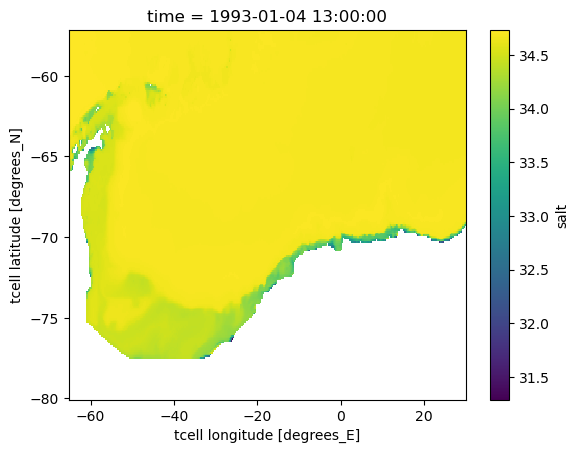

In [66]:
bottom_salt.plot()

In [67]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


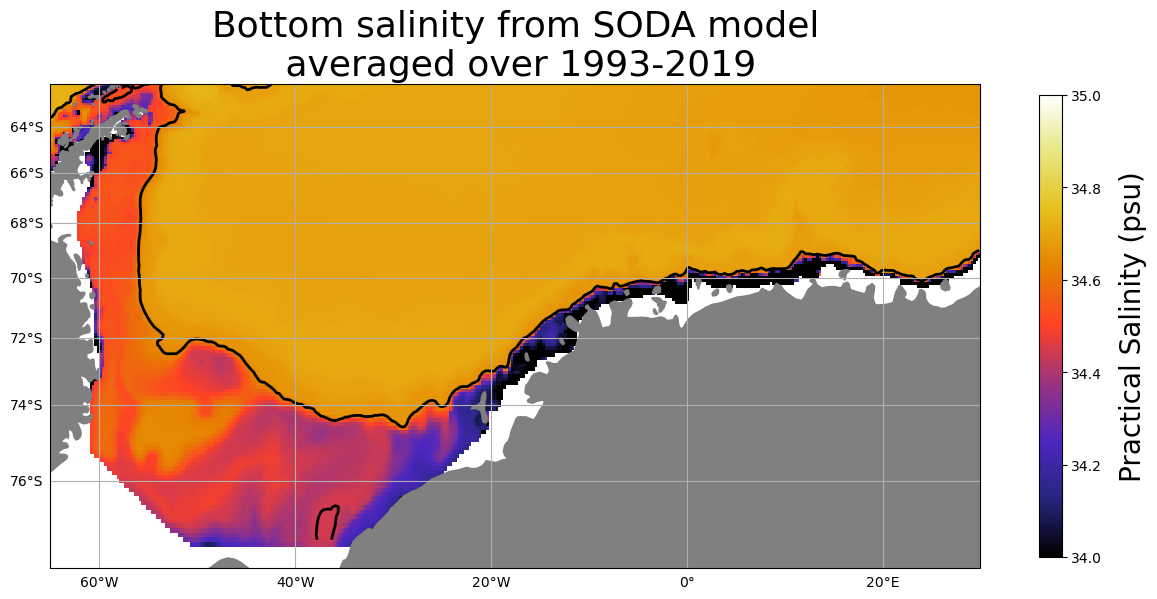

In [68]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_salt, transform=ccrs.PlateCarree(), cmap='CMRmap', vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Bottom salinity from SODA model\n averaged over 1993-2019', fontsize=26)
plt.savefig('bot-salt-soda-1kmisobath.pdf');

In [69]:
swap_slt = bottom_salt.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [70]:
bottom_salt = swap_slt.assign_coords({"lon": swap_slt.xt_ocean, 'lat':swap_slt.yt_ocean}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

In [71]:
bottom_salt

<xarray.DataArray 'salt' (lat: 208, lon: 381)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [34.720467, 34.72056 , 34.720596, ..., 34.6701  , 34.67009 ,
        34.67006 ],
       [34.720512, 34.72059 , 34.720596, ..., 34.6702  , 34.670177,
        34.670162],
       [34.720505, 34.720573, 34.720573, ..., 34.67031 , 34.670273,
        34.670235]], dtype=float32)
Coordinates:
    time     object 1993-01-04 13:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23

In [72]:
bottom_salt.to_netcdf('bottom_salt.nc')

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [ ]:
salt_std = ds_wg.salt.std(dim='time').load()

In [58]:
bottom_salt_std = salt_std.sel(st_ocean=depth_max_salt, method='nearest')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


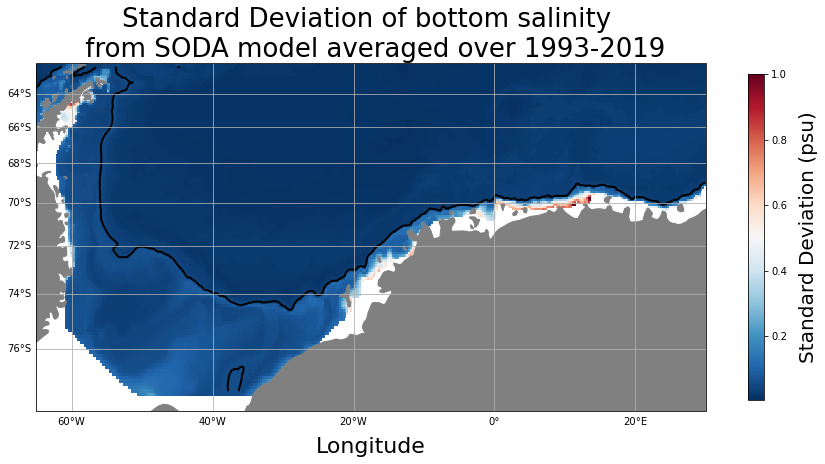

In [23]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_salt_std, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (psu)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=22)

plt.title('Standard Deviation of bottom salinity \n from SODA model averaged over 1993-2019', fontsize=26)
plt.savefig('std-bot-salt-soda-1kmisobath.pdf');

In [60]:
swap_dim_slt = bottom_salt_std.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [61]:
bottom_salt_std = swap_dim_slt.assign_coords({"lon": swap_dim_slt.xt_ocean, 
                                              'lat':swap_dim_slt.yt_ocean}).drop(['xt_ocean', 'yt_ocean', 'st_ocean'])

In [62]:
bottom_salt_std

<xarray.DataArray 'salt' (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.01667607, 0.0167114 , 0.016342  , ..., 0.01590053, 0.01613886,
        0.01642593],
       [0.01640019, 0.01632544, 0.01374952, ..., 0.01542513, 0.01547884,
        0.01569463],
       [0.01606008, 0.01450908, 0.01440152, ..., 0.0149381 , 0.01464861,
        0.01431615]], dtype=float32)
Coordinates:
    time     object 1993-01-04 13:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [63]:
bottom_salt_std.to_netcdf('bottom_salt_std.nc')

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)